## Import

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

## Config

In [3]:
# dataset
dir_data = "../data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

# features
store_features = f'../data/{provider}/features.h5'

## Pre processing

### Load Data

In [4]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

### Load Features

In [5]:
features = []
labels = []
# load features and labels for each season
for (l,s) in itertools.product(leagues, seasons):
    try:
        features.append(pd.read_hdf(store_features, key=f'{l}/{s}/features'))
        labels.append(pd.read_hdf(store_features, key=f'{l}/{s}/labels'))
    except KeyError:
        print(f"Key not found for league {l} and season {s}")
features = pd.concat(features)
labels = pd.concat(labels)
# filter open play shots
open_play_idx = features[features.type_id_a0 == 'shot'].index
features = features.loc[open_play_idx]
labels = labels.loc[open_play_idx]

display(features.head())
display(labels.to_frame().head())

type_id_a0      type_id_a1 type_id_a2 bodypart_id_a0  \
game_id action_id                                                        
2500098 17              shot         dribble      cross           foot   
        40              shot  corner_crossed       pass           foot   
        77              shot       clearance      cross           foot   
        140             shot           cross    dribble           foot   
        145             shot            pass       pass           foot   

                  bodypart_id_a1 bodypart_id_a2 result_id_a1 result_id_a2  \
game_id action_id                                                           
2500098 17                  foot           foot      success      success   
        40                  foot           foot      success         fail   
        77                  foot           foot         fail         fail   
        140                 foot           foot      success      success   
        145                 foot           foot      success      success   

                   start_x_a0  start_y_a0  ...  speed_a02  shot_angle_a0  \
game_id action_id                          ...                             
2500098 17              99.75       26.52  ...   1.319750       0.499778   
        40              91.35       35.36  ...   4.249364       0.517985   
        77              75.60       29.92  ...   5.874066       0.242481   
        140             92.40       43.52  ...   2.061543       0.371538   
        145             99.75       37.40  ...   1.289870       0.978291   

                   shot_angle_a1  shot_angle_a2  caley_zone_a0  caley_zone_a1  \
game_id action_id                                                               
2500098 17              0.483780       0.065500              2              3   
        40              0.000000       0.363334              3              8   
        77              0.491555       0.043863              6              3   
        140             0.134860       0.167545              4              5   
        145             0.654611       0.320841              1              3   

                   caley_zone_a2  angle_zone_a0  angle_zone_a1  angle_zone_a2  
game_id action_id                                                              
2500098 17                     8              9             12             18  
        40                     4             12             21             12  
        77                     0             18             12             18  
        140                    0             12             15             18  
        145                    4              6              9             15  

[5 rows x 59 columns]

goal
game_id action_id       
2500098 17         False
        40         False
        77         False
        140        False
        145        False

In [6]:
features.dtypes

type_id_a0                category
type_id_a1                category
type_id_a2                category
bodypart_id_a0            category
bodypart_id_a1            category
bodypart_id_a2            category
result_id_a1              category
result_id_a2              category
start_x_a0                 float64
start_y_a0                 float64
start_x_a1                 float64
start_y_a1                 float64
start_x_a2                 float64
start_y_a2                 float64
end_x_a1                   float64
end_y_a1                   float64
end_x_a2                   float64
end_y_a2                   float64
dx_a1                      float64
dy_a1                      float64
movement_a1                float64
dx_a2                      float64
dy_a2                      float64
movement_a2                float64
dx_a01                     float64
dy_a01                     float64
mov_a01                    float64
dx_a02                     float64
dy_a02              

### Split train and test 

In [7]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

In [8]:
for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("-" * 20)

dataset = train
shape = (20652, 59)
--------------------
dataset = val
shape = (7781, 59)
--------------------
dataset = test
shape = (11965, 59)
--------------------


## Learning 

### Feature selection

In [9]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Separate numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int']).columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# Encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_data = encoder.fit_transform(X_train[categorical_columns])

# Combine numerical and categorical data
numerical_data = X_train[numerical_columns].values
processed_data = np.hstack([numerical_data, categorical_data])

# Reshape for Conv1D
processed_data = processed_data.reshape((processed_data.shape[0], processed_data.shape[1], 1))

# Update input shape for the model
input_shape = (processed_data.shape[1], 1)



In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import brier_score_loss
from keras.models import Model

# Define custom negative Brier score metric
def negative_brier_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return -tf.reduce_mean((y_pred - y_true)**2)

# Create the model
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Feature extraction layers
    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling1D(pool_size=3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Dense layer (Feature selection happens here)
    x = tf.keras.layers.Flatten()(x)
    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)
    
    # Full model for training and evaluation
    model = tf.keras.Model(inputs, outputs)
    
    # Feature extraction model
    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor

# CNN-based feature selection
def cnn_feature_selection(trained_cnn_model, X_test, feature_names, num_features):
    """
    Perform CNN-based feature selection.

    Parameters:
        trained_cnn_model (keras.Model): Trained CNN model.
        X_test (numpy.ndarray): Testing dataset.
        feature_names (list): List of feature names corresponding to input data.
        num_features (int): Desired number of top features to select.

    Returns:
        list: Names of the selected top features.
    """
    # Extract the last convolutional layer
    last_conv_layer = None
    for layer in reversed(trained_cnn_model.layers):
        if 'conv' in layer.name:
            last_conv_layer = layer
            break

    if not last_conv_layer:
        raise ValueError("No convolutional layer found in the model.")

    # Create a new model to output the activations of the last convolutional layer
    activation_model = Model(inputs=trained_cnn_model.input, outputs=last_conv_layer.output)

    # Compute activations for the test data
    activations = activation_model.predict(X_test)

    # Calculate mean activations across all samples
    mean_activations = np.mean(activations, axis=(0, 1))  # Average across samples and spatial dimensions

    # Find the indices of the features with the highest mean activations
    top_feature_indices = np.argsort(mean_activations)[-num_features:][::-1]

    # Map indices to feature names
    index_features_cnn = []
    top_feature_names = []
    for index in top_feature_indices:
        if index < len(feature_names):
            top_feature_names.append(feature_names[index])
            index_features_cnn.append(index)

    return top_feature_names, index_features_cnn

# Compile the model
input_shape = (144, 1) 

# Build and train the model
model, feature_extractor = build_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[negative_brier_score])
model.fit(processed_data, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
1033/1033 [==============================] - 15s 13ms/step - loss: 0.3143 - negative_brier_score: -0.0880 - val_loss: 0.2684 - val_negative_brier_score: -0.0773
Epoch 2/50
1033/1033 [==============================] - 12s 12ms/step - loss: 0.2941 - negative_brier_score: -0.0838 - val_loss: 0.2635 - val_negative_brier_score: -0.0759
Epoch 3/50
1033/1033 [==============================] - 12s 11ms/step - loss: 0.2910 - negative_brier_score: -0.0832 - val_loss: 0.2756 - val_negative_brier_score: -0.0805
Epoch 4/50
1033/1033 [==============================] - 12s 11ms/step - loss: 0.2896 - negative_brier_score: -0.0828 - val_loss: 0.2714 - val_negative_brier_score: -0.0772
Epoch 5/50
1033/1033 [==============================] - 12s 12ms/step - loss: 0.2888 - negative_brier_score: -0.0826 - val_loss: 0.2702 - val_negative_brier_score: -0.0770
Epoch 6/50
1033/1033 [==============================] - 11s 11ms/step - loss: 0.2884 - negative_brier_score: -0.0825 - val_loss: 0.2628 - va

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 144, 64)           256       
                                                                 
 batch_normalization (BatchN  (None, 144, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 144, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 144, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 144, 128)         512       
 hNormalization)                                             

In [12]:
NUM = features.select_dtypes(include=['float64']).columns.tolist()

CAT = features.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical features:", NUM)
print("Categorical features:", CAT)

Numerical features: ['start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1', 'start_x_a2', 'start_y_a2', 'end_x_a1', 'end_y_a1', 'end_x_a2', 'end_y_a2', 'dx_a1', 'dy_a1', 'movement_a1', 'dx_a2', 'dy_a2', 'movement_a2', 'dx_a01', 'dy_a01', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 'start_dist_to_goal_a2', 'start_angle_to_goal_a2', 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 'end_dist_to_goal_a2', 'end_angle_to_goal_a2', 'time_delta_1', 'time_delta_2', 'speedx_a01', 'speedy_a01', 'speed_a01', 'speedx_a02', 'speedy_a02', 'speed_a02', 'shot_angle_a0', 'shot_angle_a1', 'shot_angle_a2']
Categorical features: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']


In [13]:
index_cat = []
for col in CAT:
    value_counts = features[col].value_counts()
    
    non_zero_counts = value_counts[value_counts > 1]

    for i in range(len(non_zero_counts)):
        index_cat.append(col)

index_features = index_cat + NUM
print(len(index_features))


144


In [14]:
# Handle categorical and numerical data in X_test
X_test_categorical = encoder.transform(X_test[categorical_columns])  # Encode categories
X_test_numerical = X_test[numerical_columns].values  # Extract numerical features
X_test_processed = np.hstack([X_test_numerical, X_test_categorical])  # Combine features

# Reshape for Conv1D
X_test_processed = X_test_processed.reshape((X_test_processed.shape[0], X_test_processed.shape[1], 1))

# Verify data type
X_test_processed = np.array(X_test_processed, dtype=np.float32)

In [15]:
# Perform feature selection
top_features,cnn_features_index = cnn_feature_selection(model, X_test_processed, index_features, num_features=64)
print("Top features:", top_features)
print("cnn_features_index:", cnn_features_index)

374/374 [==============================] - 1s 2ms/step
Top features: ['caley_zone_a2', 'start_y_a0', 'angle_zone_a0', 'start_dist_to_goal_a0', 'dx_a2', 'dx_a02', 'caley_zone_a1', 'caley_zone_a1', 'type_id_a1', 'start_x_a0', 'dx_a01', 'angle_zone_a0', 'start_angle_to_goal_a1', 'end_y_a1', 'angle_zone_a0', 'caley_zone_a0', 'type_id_a1', 'result_id_a1', 'type_id_a2', 'bodypart_id_a0', 'angle_zone_a1', 'type_id_a1', 'end_x_a1', 'caley_zone_a2', 'type_id_a0', 'result_id_a2', 'type_id_a2', 'start_x_a2', 'type_id_a2', 'type_id_a1', 'type_id_a2', 'type_id_a1', 'result_id_a1', 'mov_a02', 'bodypart_id_a0', 'dy_a01', 'bodypart_id_a2', 'angle_zone_a2', 'type_id_a2', 'type_id_a1', 'angle_zone_a0', 'type_id_a1', 'caley_zone_a0', 'type_id_a2', 'angle_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'bodypart_id_a1', 'caley_zone_a2', 'start_y_a1', 'bodypart_id_a1', 'start_dist_to_goal_a2', 'bodypart_id_a2', 'type_id_a1', 'caley_zone_a2', 'type_id_a1', 'type_id_a2', 'type_id_a2', 'dy_a02', 'caley_zone_a0', 

In [16]:
print(len(cnn_features_index))

64


### Logistic regression

### Train test val split for logistic regression

In [51]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

### Use the selected features from the cnn 

In [52]:
%autoreload 2
from soccer_xg.ml import logreg

In [53]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from soccer_xg.ml.preprocessing import simple_proc_for_linear_algoritms

class FeatureSelector:
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices

    def transform(self, X):
        return X[:, self.feature_indices]

    def fit(self, X, y=None):
        return self  

def logreg_gridsearch_model(
    numeric_features,
    categoric_features,
    cnn_features_index,
    n_iter=100,
    scoring='roc_auc'
):
    """
    Logistic regression pipeline with feature selection and hyperparameter tuning.
    """
    param_space = {
        'clf__C': np.logspace(-5, 5, 100),
        'clf__class_weight': ['balanced', None],
    }

    pipe = Pipeline(
        [
            ('preprocessing', simple_proc_for_linear_algoritms(
                numeric_features, categoric_features)),
            ('feature_selection', FeatureSelector(cnn_features_index)),
            ('clf', LogisticRegression(max_iter=10000, fit_intercept=False)),
        ]
    )

    return RandomizedSearchCV(
        pipe, param_space, n_iter=n_iter, scoring=scoring, cv=5
    )


In [54]:
search_logreg = logreg_gridsearch_model(
    numeric_features=NUM,
    categoric_features=CAT,
    scoring='recall',
    cnn_features_index=cnn_features_index,
    n_iter=1000
)

In [55]:
search_logreg.fit(X_train, y_train)

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 200 is smaller than n_iter=1000. Running 200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessing',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('pipeline-1',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('columnsselector',
                                                                                               ColumnsSelector(columns=['type_id_a0',
                                                                                                                        'type_id_a1',
                                                                                                                        'type_id_a2',
                                                                

In [56]:
search_logreg.best_score_

0.828978622327791

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (y_pred[y_true])[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:135: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:152: RuntimeWarning: invalid value encountered in divide
  predicted_pos_percents = np.nan_to_num(number_pos / number_total, 1)
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\visualisation.py:135: UserWarning: No artists with labels found to put in legend.  Note that artists wh

{'max_dev': 99.0, 'residual_area': 2261.030338562082, 'roc': 0.7406461254750797, 'brier': 0.24432807925042915, 'ece': 0.3872903271370195, 'ace': 0.35026275558542574, 'fig': <Figure size 720x360 with 3 Axes>}


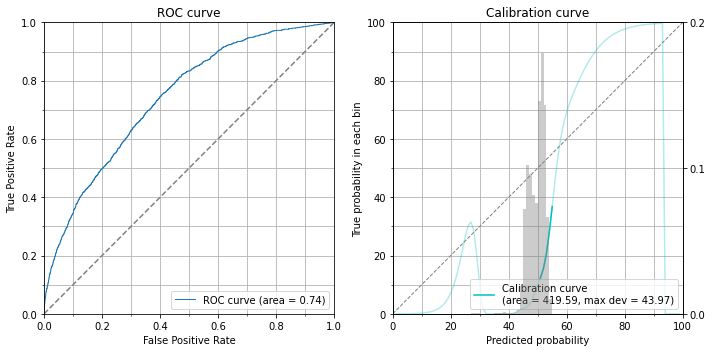

In [57]:
model = xg.OpenplayXGModel()
model.model = search_logreg.best_estimator_
model._training_seasons = ["1718"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))
#model.save_model(f'{provider}_openplay_logreg_basic')

In [58]:
preprocessing = model.model.named_steps['preprocessing']

columns_selector = preprocessing.transformer_list[0][1].named_steps['columnsselector']

selected_columns = columns_selector.columns
print("Selected Columns:", selected_columns)

print("Original NUM columns:", NUM)
print("Original CAT columns:", CAT)

Selected Columns: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']
Original NUM columns: ['start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1', 'start_x_a2', 'start_y_a2', 'end_x_a1', 'end_y_a1', 'end_x_a2', 'end_y_a2', 'dx_a1', 'dy_a1', 'movement_a1', 'dx_a2', 'dy_a2', 'movement_a2', 'dx_a01', 'dy_a01', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 'start_dist_to_goal_a2', 'start_angle_to_goal_a2', 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 'end_dist_to_goal_a2', 'end_angle_to_goal_a2', 'time_delta_1', 'time_delta_2', 'speedx_a01', 'speedy_a01', 'speed_a01', 'speedx_a02', 'speedy_a02', 'speed_a02', 'shot_angle_a0', 'shot_angle_a1', 'shot_angle_a2']
Original CAT columns: ['type_id_a0', 'type_id_a1', 'type

In [59]:
#model = xg.XGModel.load_model(f'{provider}_openplay_logreg_basic')

(pd.DataFrame(
    data={'importance': model.model.named_steps['clf'].coef_[0]},index=top_features)
    .sort_values(by='importance').to_csv("feature_importance/feature_importance_CNN_test_5_recall.csv")) #